In [87]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import datetime
from sklearn.metrics import f1_score  # Import f1_score
import numpy as np
from xgboost import XGBClassifier



train.csv shape is  (370703, 24)
test.csv shape is  (92676, 23)



                 id     unix_time            amt        cc_num            zip  \
count  3.707030e+05  3.707030e+05  370703.000000  3.707030e+05  370703.000000   
mean   4.080297e+05  1.705433e+09     123.499358  3.862304e+17   51525.494701   
std    3.361065e+05  7.615549e+05     244.813193  1.260746e+18   29974.830535   
min    0.000000e+00  1.704085e+09       1.000000  6.040027e+10    1001.000000   
25%    1.325125e+05  1.704729e+09      12.360000  1.800195e+14   27705.000000   
50%    3.162290e+05  1.705435e+09      52.210000  3.513445e+15   48214.000000   
75%    6.121395e+05  1.706073e+09     106.260000  4.643524e+15   78501.000000   
max    1.344214e+06  1.706764e+09   17620.830000  4.999601e+18   99921.000000   

                 lat           long      city_pop      merch_lat  \
count  370703.000000  370703.000000  3.707030e+05  370703.000000   
mean       37.528550     -92.158261  2.991079e+05      37.527942   

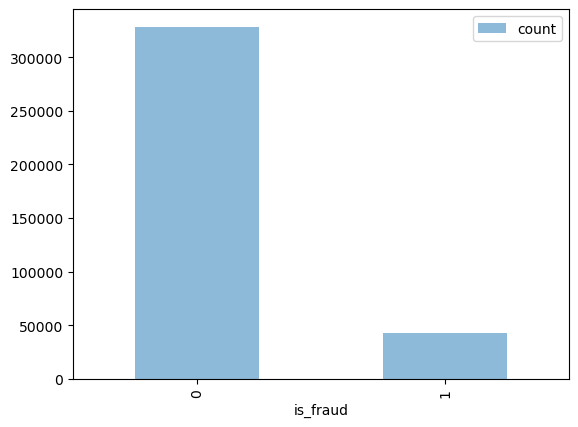


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [88]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

# print(trainingSet.head())
print()
# print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['is_fraud'].value_counts().plot(kind='bar', legend=True, alpha=.5)
print(trainingSet["is_fraud"].value_counts())
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [99]:

def distance_to_merchant(df):
    R = 6371
    
    # Convert latitude and longitude to radians
    cardholder_lat = np.radians(df['lat'])
    cardholder_long = np.radians(df['long'])
    merchant_lat = np.radians(df['merch_lat'])
    merchant_long = np.radians(df['merch_long'])
    
    # Calculate differences
    dlat = merchant_lat - cardholder_lat
    dlong = merchant_long - cardholder_long
    
    # Haversine formula
    a = np.sin(dlat/2)**2 + np.cos(cardholder_lat) * np.cos(merchant_lat) * np.sin(dlong/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c
    
    # Add the calculated distances as a new column
    df['distance_to_merchant'] = distance
    
    return df

def add_time_features(df):
    # Convert
    df['trans_datetime'] = pd.to_datetime(df['trans_date'] + ' ' + df['trans_time'])
    
    # Extract useful time components
    df['hour'] = df['trans_datetime'].dt.hour
    df['day_of_week'] = df['trans_datetime'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['is_night'] = df['hour'].between(23, 6).astype(int)
    
    return df

def amt_per_capita(df):
    df['amt_per_capita'] = df['amt'] / df['city_pop']
    return df

def age(df):
    df['age'] = (pd.to_datetime('today') - pd.to_datetime(df['dob'])).dt.days // 365
    return df

def age_group(df):
    df['age_group'] = pd.cut(df['age'], bins=[0, 20, 40, 60, 80, 100], labels=['0-20', '21-40', '41-60', '61-80', '81-100'])
    return df


def average_transaction_amount(df_train, df_test):
    # Use only the first 75% of the training data
    df_train_75 = df_train.sample(frac=0.75, random_state=0)
    
    # Calculate the average transaction amount for each user in the 75% training set
    user_avg_amt = df_train_75.groupby('cc_num')['amt'].mean().reset_index()
    user_avg_amt.columns = ['cc_num', 'avg_transaction_amt']
    
    # Merge the average transaction amount back into the training and testing sets
    df_train = df_train.merge(user_avg_amt, on='cc_num', how='left')
    df_test = df_test.merge(user_avg_amt, on='cc_num', how='left')

    # Fill missing values with the overall average transaction amount
    overall_avg_amt = df_train_75['amt'].mean()
    df_train['avg_transaction_amt'] = df_train['avg_transaction_amt'].fillna(overall_avg_amt)
    df_test['avg_transaction_amt'] = df_test['avg_transaction_amt'].fillna(overall_avg_amt)

    
    return df_train, df_test

def std_dev_transaction_amount(df_train, df_test):
    # Use only the first 75% of the training data
    df_train_75 = df_train.sample(frac=0.75, random_state=0)
    
    # Calculate the standard deviation of transaction amount for each user in the 75% training set
    user_std_dev_amt = df_train_75.groupby('cc_num')['amt'].std().reset_index()
    user_std_dev_amt.columns = ['cc_num', 'std_dev_transaction_amt']
    
    # Merge the standard deviation back into the training and testing sets
    df_train = df_train.merge(user_std_dev_amt, on='cc_num', how='left')
    df_test = df_test.merge(user_std_dev_amt, on='cc_num', how='left')

    # Fill missing values with the overall standard deviation of transaction amount
    overall_std_dev_amt = df_train_75['amt'].std()
    df_train['std_dev_transaction_amt'] = df_train['std_dev_transaction_amt'].fillna(overall_std_dev_amt)
    df_test['std_dev_transaction_amt'] = df_test['std_dev_transaction_amt'].fillna(overall_std_dev_amt)

    return df_train, df_test

def average_amount_per_merchant(df_train, df_test):

    df_train_75 = df_train.sample(frac=0.75, random_state=0)

    # Calculate the average transaction amount for each merchant
    merchant_avg_amt = df_train_75.groupby('merchant')['amt'].mean().reset_index()
    merchant_avg_amt.columns = ['merchant', 'avg_amount_per_merchant']
    
    # Merge the average amount back into the training and testing sets
    df_train = df_train.merge(merchant_avg_amt, on='merchant', how='left')
    df_test = df_test.merge(merchant_avg_amt, on='merchant', how='left')

    # Fill missing values with the overall average transaction amount
    overall_avg_amt = df_train_75['amt'].mean()
    df_train['avg_amount_per_merchant'] = df_train['avg_amount_per_merchant'].fillna(overall_avg_amt)
    df_test['avg_amount_per_merchant'] = df_test['avg_amount_per_merchant'].fillna(overall_avg_amt)

    return df_train, df_test


def std_dev_amount_per_merchant(df_train, df_test):
    
    df_train_75 = df_train.sample(frac=0.75, random_state=0)

    # Calculate the standard deviation of transaction amount for each merchant
    merchant_std_dev_amt = df_train_75.groupby('merchant')['amt'].std().reset_index()
    merchant_std_dev_amt.columns = ['merchant', 'std_dev_amount_per_merchant']
    
    # Merge the standard deviation back into the training and testing sets
    df_train = df_train.merge(merchant_std_dev_amt, on='merchant', how='left')
    df_test = df_test.merge(merchant_std_dev_amt, on='merchant', how='left')

    # Fill missing values with the overall standard deviation of transaction amount
    overall_std_dev_amt = df_train_75['amt'].std()
    df_train['std_dev_amount_per_merchant'] = df_train['std_dev_amount_per_merchant'].fillna(overall_std_dev_amt)
    df_test['std_dev_amount_per_merchant'] = df_test['std_dev_amount_per_merchant'].fillna(overall_std_dev_amt)

    return df_train, df_test


def average_amount_per_category(df_train, df_test):
    df_train_75 = df_train.sample(frac=0.75, random_state=0)

    # Calculate the average transaction amount for each category
    category_avg_amt = df_train_75.groupby('category')['amt'].mean().reset_index()
    category_avg_amt.columns = ['category', 'avg_amount_per_category']
    
    # Merge the average amount back into the training and testing sets
    df_train = df_train.merge(category_avg_amt, on='category', how='left')
    df_test = df_test.merge(category_avg_amt, on='category', how='left')

    # Fill missing values with the overall average transaction amount
    overall_avg_amt = df_train_75['amt'].mean()
    df_train['avg_amount_per_category'] = df_train['avg_amount_per_category'].fillna(overall_avg_amt)
    df_test['avg_amount_per_category'] = df_test['avg_amount_per_category'].fillna(overall_avg_amt)

    return df_train, df_test



def std_dev_amount_per_category(df_train, df_test):
    df_train_75 = df_train.sample(frac=0.75, random_state=0)

    # Calculate the standard deviation of transaction amount for each category
    category_std_dev_amt = df_train_75.groupby('category')['amt'].std().reset_index()
    category_std_dev_amt.columns = ['category', 'std_dev_amount_per_category']
    
    # Merge the standard deviation back into the training and testing sets
    df_train = df_train.merge(category_std_dev_amt, on='category', how='left')
    df_test = df_test.merge(category_std_dev_amt, on='category', how='left')

    # Fill missing values with the overall standard deviation of transaction amount
    overall_std_dev_amt = df_train_75['amt'].std()
    df_train['std_dev_amount_per_category'] = df_train['std_dev_amount_per_category'].fillna(overall_std_dev_amt)
    df_test['std_dev_amount_per_category'] = df_test['std_dev_amount_per_category'].fillna(overall_std_dev_amt)

    return df_train, df_test


def average_amount_per_job(df_train, df_test):
    df_train_75 = df_train.sample(frac=0.75, random_state=0)

    # Calculate the average transaction amount for each job
    job_avg_amt = df_train_75.groupby('job')['amt'].mean().reset_index()
    job_avg_amt.columns = ['job', 'avg_amount_per_job']
    
    # Merge the average amount back into the training and testing sets
    df_train = df_train.merge(job_avg_amt, on='job', how='left')
    df_test = df_test.merge(job_avg_amt, on='job', how='left')

    # Fill missing values with the overall average transaction amount
    overall_avg_amt = df_train_75['amt'].mean()
    df_train['avg_amount_per_job'] = df_train['avg_amount_per_job'].fillna(overall_avg_amt)
    df_test['avg_amount_per_job'] = df_test['avg_amount_per_job'].fillna(overall_avg_amt)

    return df_train, df_test

def std_dev_amount_per_job(df_train, df_test):
    df_train_75 = df_train.sample(frac=0.75, random_state=0)

    # Calculate the standard deviation of transaction amount for each job
    job_std_dev_amt = df_train_75.groupby('job')['amt'].std().reset_index()
    job_std_dev_amt.columns = ['job', 'std_dev_amount_per_job']
    
    # Merge the standard deviation back into the training and testing sets
    df_train = df_train.merge(job_std_dev_amt, on='job', how='left')
    df_test = df_test.merge(job_std_dev_amt, on='job', how='left')

    # Fill missing values with the overall standard deviation of transaction amount
    overall_std_dev_amt = df_train_75['amt'].std()
    df_train['std_dev_amount_per_job'] = df_train['std_dev_amount_per_job'].fillna(overall_std_dev_amt)
    df_test['std_dev_amount_per_job'] = df_test['std_dev_amount_per_job'].fillna(overall_std_dev_amt)

    return df_train, df_test




def add_features_to(df1, df2):
    df1 = distance_to_merchant(df1)
    df1 = add_time_features(df1)
    df1 = amt_per_capita(df1)
    df1 = age(df1)
    df1 = age_group(df1)
    

    df2 = distance_to_merchant(df2)
    df2 = add_time_features(df2)
    df2 = amt_per_capita(df2)
    df2 = age(df2)
    df2 = age_group(df2)

    df1, df2 = average_transaction_amount(df1, df2)
    df1, df2 = average_amount_per_merchant(df1, df2)
    df1, df2 = average_amount_per_category(df1, df2)
    df1, df2 = average_amount_per_job(df1, df2)
    df1, df2 = std_dev_transaction_amount(df1, df2)
    df1, df2 = std_dev_amount_per_merchant(df1, df2)
    df1, df2 = std_dev_amount_per_category(df1, df2)
    df1, df2 = std_dev_amount_per_job(df1, df2)

    return df1, df2


if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")

else:
    X_train, X_test_full = add_features_to(trainingSet,testingSet)



In [100]:
null_columns = X_train.columns[X_train.isnull().any()].tolist()
null_counts = X_train[null_columns].isnull().sum()

print("Columns with null values:")
for col, count in null_counts.items():
    print(f"{col}: {count} nulls")

Columns with null values:


In [101]:
null_columns = X_test_full.columns[X_test_full.isnull().any()].tolist()
null_counts = X_test_full[null_columns].isnull().sum()

print("Columns with null values:")
for col, count in null_counts.items():
    print(f"{col}: {count} nulls")

Columns with null values:


In [102]:
print(X_train.shape)
print(X_test_full.shape)

(370703, 41)
(92676, 40)


In [103]:
# Split training set into training and testing set

X_train_subset = X_train
print(X_train_subset.shape)
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train_subset.drop(columns=['is_fraud']),
    X_train_subset['is_fraud'],
    test_size=1/4.0,
    random_state=0
)

(370703, 41)


In [104]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(278027, 40)
(92676, 40)
(278027,)
(92676,)


In [105]:

non_numeric_features = X_train.select_dtypes(exclude=['number']).columns.tolist()
numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()
features = numeric_features 

In [106]:
X_train_subset = X_train[features]
X_test_subset = X_test[features]

/Users/nikhilramchandani/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:12:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score (XGBoost): 0.9721494882170911


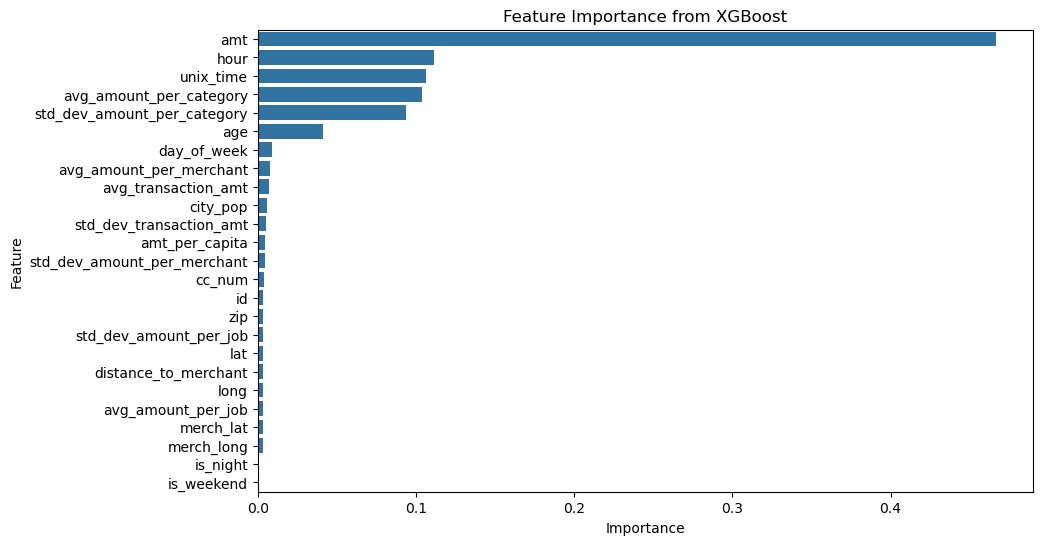

In [107]:
# Train an XGBoost model
xgb_model = XGBClassifier(n_estimators=200, max_depth=10, random_state=0, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_subset, Y_train)

Y_pred_xgb = xgb_model.predict(X_test_subset)
f1_xgb = f1_score(Y_test, Y_pred_xgb)

print(f"F1 Score (XGBoost): {f1_xgb}")
importances_xgb = xgb_model.feature_importances_

feature_importance_df_xgb = pd.DataFrame({
    'Feature': features,
    'Importance': importances_xgb
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_xgb)
plt.title('Feature Importance from XGBoost')
plt.show()

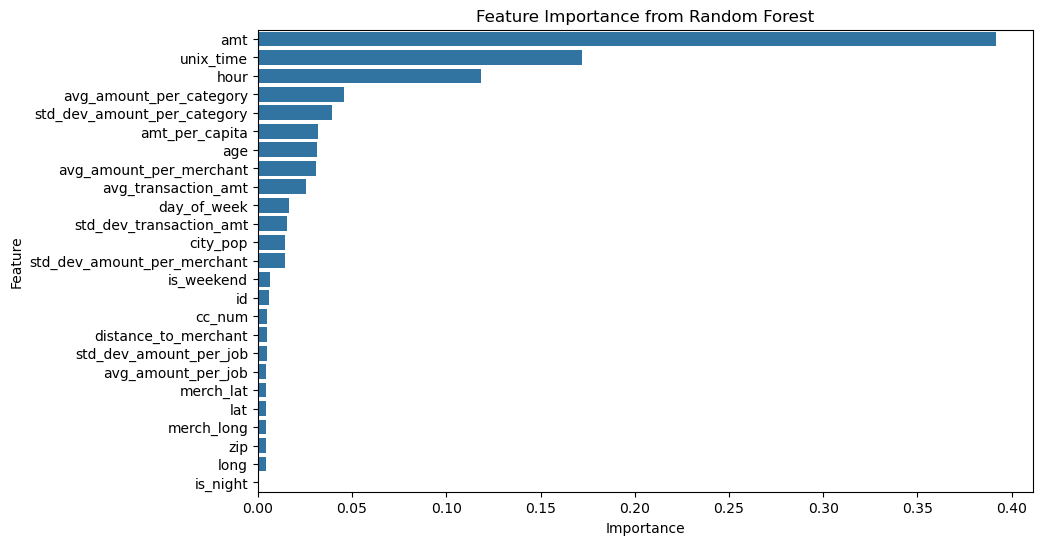

F1 Score: 0.9648595813665188


In [108]:
# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100,max_depth=20, random_state=0)
rf_model.fit(X_train_subset, Y_train)
features = X_train_subset.columns.tolist()

# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance from Random Forest')
plt.show()

Y_pred = rf_model.predict(X_test_subset)  # Add this line to get predictions
f1 = f1_score(Y_test, Y_pred)  # Add this line to calculate F1 score
print(f"F1 Score: {f1}")  # Add this line to print the F1 score


In [109]:
# Predict with XGBoost model
X_test_predict_xgb = X_test_full[features]
test_predictions_xgb = xgb_model.predict(X_test_predict_xgb)

# Create a submission DataFrame
submission_xgb = pd.DataFrame({
    'id': testingSet['id'],
    'is_fraud': test_predictions_xgb
})

# Save predictions to a CSV file
submission_xgb.to_csv('./data/predictions_xgb.csv', index=False)
print("Predictions saved to 'predictions_xgb.csv'")
print("Distribution of predictions:")
print(pd.Series(test_predictions_xgb).value_counts())

Predictions saved to 'predictions_xgb.csv'
Distribution of predictions:
0    82392
1    10284
Name: count, dtype: int64
